In [9]:
import pandas as pd
import numpy as np
import plotly
import plotly.express as px
import plotly.graph_objects as go

hh_db = pd.read_csv('data/hh_database.csv', sep=';')
rough_data = hh_db.copy()
#display(rough_data)
#display(rough_data.iloc[:,9].value_counts())

def pull_data(arg):
    edu_type_lst = list(arg.split())

    if edu_type_lst[0] == 'Высшее':
        return 'Высшее'
    elif edu_type_lst[0] == 'Неоконченное':
        return 'Неоконченное высшее'
    elif ((edu_type_lst[0] + ' ' + edu_type_lst[1]) == 'Среднее специальное') :
        return 'Среднее специальное'
    else:
        return 'Cреднее'
rough_data['Образование'] = rough_data['Образование и ВУЗ'].apply(pull_data)
#display(rough_data['Образование'].value_counts())
rough_data = rough_data.drop(['Образование и ВУЗ'], axis=1)
    
rough_data['Возраст'] = rough_data['Пол, возраст'].apply(lambda age: int((list(age.split(','))[1][2:4])))
rough_data['Пол'] = rough_data['Пол, возраст'].apply(lambda sex:'М' if 'Мужчина ' in sex.split(',') else 'Ж')
rough_data['Пол'] = rough_data['Пол'].astype('string')
rough_data = rough_data.drop(['Пол, возраст'], axis=1)
#rough_data['Пол'].value_counts(normalize=True)
#rough_data['Возраст'].mean()
        
def get_experience(arg):
    if type(arg) is str: 
        if arg =='Не указано': return np.nan
        else: 
           cell = arg.split()
           try:
               if int(cell[2]) and int(cell[4]): return int(cell[2])*12+int(cell[4])
           except ValueError:
               if (cell[3] == 'месяца') or (cell[3] =='месяцев'):
                   return int(cell[2])
               else: return int(cell[2])*12
    else: return np.nan

rough_data['Опыт работы (месяц)'] = rough_data['Опыт работы'].apply(get_experience)
rough_data = rough_data.drop(['Опыт работы'], axis=1)
#display(rough_data['Опыт работы (месяц)'].median())

def city(arg):
    million_cities = ['Новосибирск', 'Екатеринбург', 'Нижний Новгород', 'Казань', 'Челябинск', 'Омск', 
                      'Самара', 'Ростов-на-Дону', 'Уфа', 'Красноярск', 'Пермь', 'Воронеж', 'Волгоград']
    arg_str = arg.replace(',', '')
    arg_str = arg_str.split()[0]
    if arg_str in ['Москва', 'Санкт-Петербург']:
        return arg_str
    elif arg_str in million_cities:
        return 'город-миллионник'
    else: return 'другие'
rough_data['Город'] = rough_data['Город, переезд, командировки'].apply(city)
#display(rough_data['Город'].value_counts(normalize=True)*100)

def relocation(arg):
    arg=arg[arg.find(',')+2:]
    if arg[0:3]==' м.':
        arg=arg[arg.find(',')+2:]
    arg=arg[:arg.find(',')]
    arg_lst=list(arg.split())
    if 'не' in arg_lst: return False
    else: return True

rough_data['Готовность к переезду'] = rough_data['Город, переезд, командировки'].apply(relocation)  

#display(rough_data['Город, переезд, командировки'].value_counts())

def business_trip(arg):
    arg=arg[arg.rfind(','):]
    arg_lst=list(arg.split())
    if ('командировкам' not in arg_lst) or ('не' in arg_lst): return False
    else: return True
    
rough_data['Готовность к командировкам'] = rough_data['Город, переезд, командировки'].apply(business_trip)
rough_data = rough_data.drop(['Город, переезд, командировки'], axis=1)
rough_data
#display((rough_data.groupby('Готовность к переезду')['Готовность к командировкам'].value_counts()
#        /rough_data['Готовность к переезду'].count())*100)

def work_type(arg):
    variaties = {'полная занятость':False, 
                 'частичная занятость':False, 
                 'проектная работа':False, 
                 'волонтерство':False, 
                 'стажировка':False}
    arg_lst=list(arg.split(','))
    for i in range(len(arg_lst)):
        if arg_lst[i][0] == ' ':
            arg_lst[i] = arg_lst[i][1:]
        if  arg_lst[i] in variaties: 
            variaties[arg_lst[i]] = True
    return variaties.values()

rough_data['полная занятость'], rough_data['частичная занятость'], rough_data['проектная работа'], \
    rough_data['волонтерство'], rough_data['стажировка'] = zip(*rough_data['Занятость'].map(work_type))
    
    
def schedule(arg):
    variaties = {'полный день':False, 
                 'сменный график':False, 
                 'гибкий график':False, 
                 'удаленная работа':False, 
                 'вахтовый метод':False}
    arg_lst=list(arg.split(','))
    for i in range(len(arg_lst)):
        if arg_lst[i][0] == ' ':
            arg_lst[i] = arg_lst[i][1:]
        if  arg_lst[i] in variaties: 
            variaties[arg_lst[i]] = True
    return variaties.values()

rough_data['полный день'], rough_data['сменный график'], rough_data['гибкий график'], \
    rough_data['удаленная работа'], rough_data['вахтовый метод'] = zip(*rough_data['График'].map(schedule))
    
rough_data = rough_data.drop(['График', 'Занятость'], axis=1)
#display(rough_data.groupby('проектная работа')['волонтерство'].value_counts())

ExchangeRates = pd.read_csv('data/ExchangeRates.csv', sep=',')
ExchangeRates['date'] = pd.to_datetime(ExchangeRates['date'], dayfirst = True)
ExchangeRates = ExchangeRates.drop(['per', 'vol','time'], axis=1)
rough_data['Обновление резюме'] = pd.to_datetime(rough_data['Обновление резюме'], dayfirst = True).dt.date
rough_data['Обновление резюме'] = pd.to_datetime(rough_data['Обновление резюме'])


def salary(arg):
    curancy = {'руб':'RUR','грн':'UAH', 'бел':'BYN', 'сум':'UZS'}
    arg_lst = arg.split()
    if arg_lst[1][:3] in curancy:
        arg_lst[1]=curancy[arg_lst[1][:3]]
    return arg_lst[0], arg_lst[1]
    
rough_data['ЗП'],rough_data['валюта'] = zip(*rough_data['ЗП'].map(salary))

merged_data = rough_data.merge(ExchangeRates, how = 'left', \
    left_on = ['Обновление резюме', 'валюта'], right_on = ['date', 'currency'])
merged_data['close'] = merged_data['close'].fillna(1)
merged_data['proportion'] = merged_data['proportion'].fillna(1)
merged_data['ЗП'] = merged_data['ЗП'].astype('float')
merged_data['ЗП'] = merged_data['close']/merged_data['proportion']*merged_data['ЗП']

merged_data = merged_data.drop(['currency', 'date', 'close', 'proportion', 'валюта'], axis=1)

In [ ]:
# как остатвить только необходимое значение??
print('Значение моды для признака "Возраст":',merged_data['Возраст'].mode())
#строим график для задания 4.1
fig = px.violin(merged_data, 
                x="Возраст", #ось абсцис
                box=True, # дополнительное отражение коробчатой диаграммы
                points='all', #дополнительное отображение значений признака в виде диаграммы рассеивания 
                title = 'Распределение признака «Возраст»', #заголовок
                width = 900 # ширина графика
               )
fig.show() #отображаем график
fig.write_html("data/Распределение признака «Возраст».html") #сохраняем график

Мода призанка "Возраст" равна 30 годам.
Минимальный возраст соискателя 10 лет. Максимальный 77 лет.
Возраст большинства сосискателей сосредоточен в диапазоне 27-36 лет.
К аномалиям можно отнести соискателей с возрастом менее 18 лет и более 65 лет.

In [ ]:
print('Значение моды для признака "Опыт работы", мес.:', merged_data['ЗП'].mode())

#строим график для задания 4.2
fig = px.violin(merged_data, 
                x="Опыт работы (месяц)", #ось абсцис
                box=True, # дополнительное отражение коробчатой диаграммы
                points='all', #дополнительное отображение значений признака в виде диаграммы рассеивания 
                title = 'Распределение признака «Опыт работы (месяц)»', #заголовок
                width = 900# ширина графика
               )
fig.show() #отображаем график
fig.write_html("data/Распределение признака Опыт работы.html") #сохраняем график

Мода призанка "Опыт работы (месяц)" равна 81 месяцу.
Минимальное знаение в признаке 2 месяца. Максимальное 1188 месяцев.
Опыт работы большинства сосискателей сосредоточен в диапазоне 57-154 месяцев.
К аномалиям можно отнести соискателей с опытом работы более 600 месяцев (50 лет).

In [ ]:
print('Значение моды для признака "ЗП", руб.:', merged_data['ЗП'].mode())

#строим график для задания 4.3
fig = px.violin(merged_data, 
                x="ЗП", #ось абсцис
                #box=True, # дополнительное отражение коробчатой диаграммы
                points='all', #дополнительное отображение значений признака в виде диаграммы рассеивания 
                title = 'Распределение признака "ЗП", руб.', #заголовок
                width = 2000, # ширина графика
               )
fig.show() #отображаем график
fig.write_html("data/Распределение признака ЗП.html") #сохраняем график

Мода призанка "ЗП" равна 50000 рублей.
Минимальное знаение в признаке 1 рубль. Максимальное 24304880 рублей.
Большинство сосискателей ожидают мотивацию в диапазоне 37000 - 95000 рублей.
К аномалиям можно отнести соискателей с зарплатным ожиданием менее 15000 рублей более 500000 рублей.

In [ ]:
temp = merged_data[merged_data['ЗП']<1000000] #формируем df
temp = temp.groupby('Образование', as_index=False).median() #формируем значение
#строим график для задания 4.4
fig = px.bar(
    temp.sort_values(by = 'ЗП', ascending=False), #DataFrame
    x = 'Образование', #ось абсцисс
    y = 'ЗП', #ось ординат
    width = 800, #ширина
    height = 500, #высота
    title = "Зависимость медианной желаемой заработной платы от уровня образования" #заголовок
    );
fig.show() #отображаем график
fig.write_html("data/Зависимость медианной желаемой заработной платы от уровня образования.html") #сохраняем график

Вывод: наибольший уровень заработной платы ожидают соискатели с высшим и неоконченным высшим образованием. 60000 рублей и 50000 рублей соответственно. Меньшие мотивационные ожидания у соискателей со средним и средне специальным образованием - 40000 рублей.
Для прогнозирования заработной платы соискатлей работы в сфере ИТ уровень образования имеет значение. Но не для всех других направлений это работает.

In [ ]:
temp = merged_data[merged_data['ЗП']<1000000] #формируем df
display(temp.groupby('Город', as_index=False)['ЗП'].max())
temp = temp.groupby('Город', as_index=False).median() #формируем df
#строим график для задания 4.5
fig = px.bar(
    temp.sort_values(by = 'ЗП', ascending=False), #DataFrame
    x = 'Город', #ось абсцисс
    y = 'ЗП', #ось ординат
    width = 800, #ширина
    height = 500, #высота
    title = "Зависимость медианной желаемой заработной платы от локации" #заголовок
    );
fig.show() #отображаем график
fig.write_html("data/Зависимость медианной желаемой заработной платы от локации.html") #сохраняем график

Медианный уровень ожидаемой заработной платы в городах-миллионниках и "других" вдвое (точнее в 2.125) меньше того же уровня, чем в Москве. И в полтора раза меньше, чем в Санкт-Петербурге.
Для прогнозирования заработной платы соискатлей локация работодателя имеет значение.

In [34]:
temp = merged_data.pivot_table(
    values='ЗП',
    index= 'Готовность к переезду',
    columns='Готовность к командировкам',
    aggfunc='median') # формируем df

#строим график для задания 4.6
fig = px.bar(
    temp, #DataFrame
    title = "Зависимость медианной заработной платы от готовности к переезду и к командировкам", #заголовок
    text_auto = True #отображаем значения на самих столбцах
    );
fig.show() #отображаем график
fig.write_html("data/Зависимость медианной заработной платы от переезда и командировок.html") #сохраняем график

Соискатели готовые к переезду в целом рассчитывают на больший уровень мотивации. Вероятность командировок повышает зарплатные ожидания в ~1,3 раза для готовых и не готовых к релокации соискателей.

In [ ]:
temp = merged_data.pivot_table(
    values='ЗП',
    index= 'Возраст',
    columns='Образование',
    aggfunc='median') # формируем df

#строим график для задания 4.7
fig = px.imshow(
    temp, #DataFrame
    title = "ЗЗависимость медианной заработной платы от Возраста и Образования", #заголовок
    );
fig.show() #отображаем график
fig.write_html("data/Зависимость медианной заработной платы от Возраста и Образования.html") #сохраняем график

Для категории соискателей с высшим образованием характерен плавный рост и плавный спад на рубеже 40 лет по ожидаемой заработной плате. Присутствует единичное ожидание более высокой оплаты труда в возрасте 69 лет. Для данной категории наблюдается системная готовность к работе после 60 лет. Присутствуют выбросы по возрасту до 18 лет.
Для категории соискателей с неоконченным высшим образованием характерен плавный рост (до 42 лет) и более интенсивный спад по ожидаемой заработной плате. Присутствует единичное ожидание более высокой оплаты труда в возрасте 58 лет.
Для категории соискателей с средним и средне специальным образованием значения ожидаемой заработной платы не имеют значительной разницы в зависимости от возраста. Присутствуют единичные выбросы по уровню оплаты труда и возрасту. Присутствуют выбросы по возрасту до 18 лет.

In [ ]:
merged_data.rename(columns = {'Опыт работы (месяц)':'Опыт работы'}, inplace = True) #переименовываем признак
#temp = merged_data.copy()
merged_data['Опыт работы'] = merged_data['Опыт работы']/12

#строим график для задания 4.8
fig = px.scatter(
    merged_data, #DataFrame
    x="Возраст", #ось абсцисс
    y="Опыт работы", #ось ординат
    height=850, #высота
    width=850, #ширина
    title = "Зависимость опыта работы от возраста", #заголовок
    );
fig.add_trace(
    go.Scatter(
        x=[0, 100],
        y=[0, 100],
        mode="lines",
        line=go.scatter.Line(color="gray"),
        showlegend=False)
)
fig.show() #отображаем график
fig.write_html("data/Зависимость опыта работы от возраста.html") #сохраняем график


In [37]:
#строим график для задания 4.8
#merged_data.info()

temp = merged_data.pivot_table(
    values='ЗП',
    index= 'Образование',
    columns='Пол',
    aggfunc='mean') # формируем df

#строим график для задания 4.6
fig = px.bar(
    temp, #DataFrame
    title = "Зависимость средней заработной платы от пола и образования", #заголовок
    text_auto = True #отображаем значения на самих столбцах
    );
fig.show() #отображаем график
fig.write_html("data/Зависимость средней заработной платы от пола и образования.html") #сохраняем график

Число выбросов по методу z-отклонения: 3
Результирующее число записей: 44482


,ЗП,Ищет работу на должность:,Последнее/нынешнее место работы,Последняя/нынешняя должность,Обновление резюме,Авто,Образование,Возраст,Пол,Опыт работы,...,полная занятость,частичная занятость,проектная работа,волонтерство,стажировка,полный день,сменный график,гибкий график,удаленная работа,вахтовый метод
31137,10000.0,Менеджер по работе с клиентами,"ООО ""ФёрстКэшКомпани""",Менеджер по работе с клиентами,2019-04-06,Не указано,Cреднее,15,М,0.166667,...,False,True,False,False,False,False,True,True,True,False
32950,2000.0,Тестировщик игр,OOO ЖМЫХ,Тестировщик ПО,2019-04-09,Не указано,Среднее специальное,15,М,0.250000,...,True,False,False,False,False,True,False,False,False,False
33654,60000.0,Frontend-разработчик,Freelance,Frontend-разработчик,2019-04-19,Не указано,Среднее специальное,10,М,2.500000,...,True,True,True,False,True,True,False,True,True,False


<class 'pandas.core.frame.DataFrame'>
Int64Index: 44482 entries, 0 to 44743
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   ЗП                               44482 non-null  float64       
 1   Ищет работу на должность:        44482 non-null  object        
 2   Последнее/нынешнее место работы  44482 non-null  object        
 3   Последняя/нынешняя должность     44482 non-null  object        
 4   Обновление резюме                44482 non-null  datetime64[ns]
 5   Авто                             44482 non-null  object        
 6   Образование                      44482 non-null  object        
 7   Возраст                          44482 non-null  int64         
 8   Пол                              44482 non-null  string        
 9   Опыт работы                      44482 non-null  float64       
 10  Город                            44482 non-null  object   

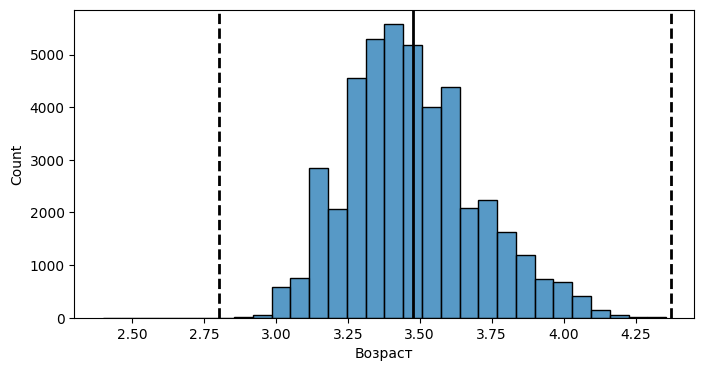

In [3]:
merged_data.duplicated() #проверяем наличие дубликатов
merged_data = merged_data.drop_duplicates() #удалем их
#display(merged_data.info())

mask = ['Последнее/нынешнее место работы', 'Последняя/нынешняя должность'] #маска пропусков
#удаляем строки по маске пропусков
merged_data = merged_data.dropna(subset=mask, axis=0)
# заполняем пропуски медианным значением
merged_data = merged_data.fillna({'Опыт работы': merged_data['Опыт работы'].median()}) 
# удаляем строки, где заработная плата либо выше 1 миллиона рублей, либо ниже 1 тысячи рублей
merged_data = merged_data.drop(merged_data[(merged_data['ЗП'] > 1000000) | (merged_data['ЗП'] < 1000)].index, axis=0)
# удаляем строки, в которых опыт работы в годах превышал возраст соискателя
merged_data = merged_data.drop(merged_data[merged_data['Опыт работы'] > merged_data['Возраст']].index, axis=0)

import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
log_age = np.log(merged_data['Возраст'] + 1)
histplot = sns.histplot(log_age, bins=30, ax=ax)
histplot.axvline(log_age.mean(), color='k', lw=2)
histplot.axvline(log_age.mean()+ 4 * log_age.std(), color='k', ls='--', lw=2)
histplot.axvline(log_age.mean()- 3 * log_age.std(), color='k', ls='--', lw=2)

def outliers_z_score_mod(data, feature, log_scale=False, left = 3, right = 3):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - left * sigma
    upper_bound = mu + right * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    return outliers, cleaned
outliers, cleaned = outliers_z_score_mod(merged_data, 'Возраст', log_scale=True, left = 3, right = 4)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')
display(outliers)
merged_data = merged_data.drop(outliers.index, axis=0)
merged_data.info()

Логарифмическое распределение асимметрично в левую сторону. В "выбросы" попали резюме соискателей возрастом младше 18 лет.